# Random walk, con't

In the first notebook of the open course [**"Practical Numerical Methods with Python"**](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about) we discussed how the spreading of a quantity such as the concentration of food dye in a liquid could be described through a diffusion equation. We also started to consider another method which involves the modeling of the trajectories of the molecules. Now that we have learned more about random numbers in the second notebook of this module, we are ready to move forward and implement this second method.

## Stochastic equation for Brownian motion

The model equation we introduced for the evolution of the position of a molecule of dye is:

$$
dx=x(t+dt)−x(t)=ds
$$

$ds$ is a displacement resulting from the collision with surrounding water molecules and needs to be properly modelled. Technically speaking, the equation above is called a *stochastic differential equation* (SDE) as it contains a stochastic (or random) contribution. There are many phenomena that are modelled with such equations; besides Brownian motion, it is also widely used for the modelling of financial instruments like options.

Focusing for now on Brownian motion, let's see what happens if we model $ds$ as:

$$
ds=\sqrt{2\alpha dt}\cal{N(0,1)}
$$

where $\alpha$ is the same diffusion coefficient that one would use in the diffusion equation. Moreover, at each time step, $\cal{N(0,1)}$ is a random number that is generated from a normal (Gaussian) distribution $f(n)$, centered around $0$, and with variance equal to $1$. That is:

$$
f(n)=\frac{1}{\sqrt{2\pi}}e^{-\frac12 n^2}
$$

Below we will use Numpy's built-in function to sample the Gaussian distribution. In the previous notebook you learned to program your own version of such a routine so feel free to use it instead!

Here, we assume for simplicity that the Brownian motion takes place in a one-dimensional system. It is easy to extend the model to 2D or 3D problems by adding an identical equation for each extra dimension. 

### Integration of stochastic motion

It's now time to integrate our stochastic equation. We begin by importing our usual set of libraries:

In [3]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 22

To warm up, we only track a particle originally at rest at $x=0$.

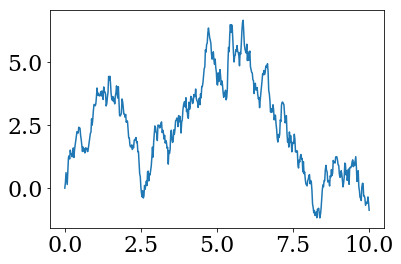

In [4]:
# Total simulation time
T=10.0

# Number of time steps and time interval dt
nt=500
dt=T/nt

# Diffusion coefficient
alpha=2.0

# Particle positions and initial condition
t = numpy.arange(0,T+dt,dt)
x = numpy.empty(nt+1)
x[0]=0

# Time integration (note the use of the numpy.random.normal function)
for i in range(nt):
    x[i+1]=x[i]+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1)

pyplot.plot(t,x)



As expected, we see that $x$ evolves in an erratic way, with random jumps (positive or negative) between each time instant. This is encouraging, but we need to verify that our model for $ds$ is indeed able to reproduce a diffusion process. 

### Comparison with the diffusion equation

In order to estimate the evolution of a our dye, we need to follow the trajectories of a sample of molecules. From their positions, we can compute the predicted density of molecules through the expression,

$$
\rho(x,t) dx=n(x,t)/N
$$

where $n(x,t)$ represents, at a given time, the number of molecules of dye contained within an interval $dx$ centered around $x$ and $N$ is the total number of molecules used in the sample.

To test our stochastic model and make the comparison with the diffusion equation, we initialise the position of our sample of molecules with a Gaussian distribution:

$$
P(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$ 

where $\sigma^2$ is the variance of the positions and $\mu$ is their average. As $n(x,0)=NP(x)dx$, we have $\rho(x,0)=P(x)$. In this case, the solution of the diffusion equation,

$$
\frac{\partial \rho}{\partial t}=\alpha \frac{\partial^2 \rho}{\partial x^2}
$$

can be computed exactly and is given by:

$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-\mu)^2}{2\sigma_t^2}}
$$

with $\sigma^2_t = 2\alpha t + \sigma^2$. If all goes well we should recover this solution using our random walk technique.

Let us first initialise the positions of our sample molecules (we will follow 100000 of them) and check that their positions is distributed as expected:

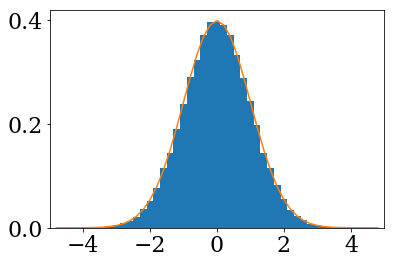

In [5]:
# Generate a set of initial positions based on the Gaussian distribution
npart=100000

# We set mu=0
sigma = 1.0
x0 = numpy.random.normal(loc=0,scale=sigma,size=npart)

# Generate bins centered around 0
binwidth=0.2
bins=numpy.arange(-5,5,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# Plot the histogram and expected distribution
pyplot.xlim(-5,5)
pyplot.hist(x0,bins,density=True);
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/(2.0*sigma**2))/numpy.sqrt(2*numpy.pi*sigma**2))

Looks good! Now we compute the trajectories of the molecules and plot 20 of them as an illustration.  

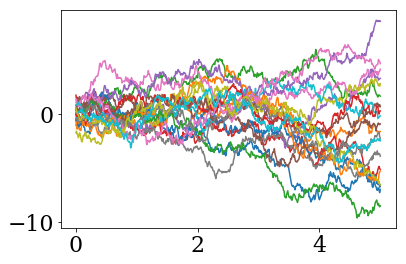

In [6]:
T=5.0
nt=500
dt=T/nt
alpha=2.0

t = numpy.arange(0,T+dt,dt)
x = numpy.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)

for i in range(20):
    pyplot.plot(t,x[:,i])

As required, the molecules follow very different trajectories. The sample is initially packed close to 0, but as time evoles, the molecules spread on average more and more. Let us now plot the histogram of the positions at the end of the simulation and compare it to the analytical solution of the diffusion equation:

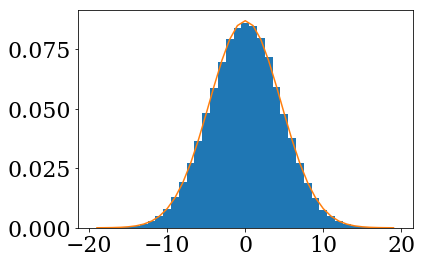

In [7]:
# Generate bins centered around 0
binwidth=1
bins=numpy.arange(-20,20,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
pyplot.hist(x[nt],bins,density=True);

sigmat2=2*alpha*T+sigma**2
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/(2.0*sigmat2))/numpy.sqrt(2*numpy.pi*sigmat2))

Pretty good! Our particles have followed random trajectories but the evolution of their density is the same as if it was computed using the diffusion equation. Play with the parameters of the problem $(\alpha, \mu, \sigma, npart)$ and check that the algorithm works as expected.

## Convergence study

Let's check the convergence of the algotirthm with respect to the number of steps $n_t$. To do so we will fix all the other computational parameters, here we'll take $\alpha=2.0$, $\mu=0.0$, $\sigma=1.0$, $N_\mathrm{part}=50000$, and $T_\mathrm{end}=5.0$, and compare the final results for each $n_t$ tested with the solution of the diffusion equation. The average error $\langle | \rho_{simul} - \rho_{th} | \rangle$ will be stored into an array to check how the average error evolves as $n_t$ gets bigger. Plus, the time needed to do the simulation can also be studied as a function of $n_t$. 

In [8]:
def sol_diff(x, sigma, t, alpha, mu = 0): 
    sigmat2 = 2*alpha*t+sigma**2
    sol = numpy.exp(-(x-mu)**2/(2.0*sigmat2))/numpy.sqrt(2*numpy.pi*sigmat2)
    return sol

In [9]:
import time

alpha=2.0
mu = 0.0
sigma = 1.0
npart = 50000
T=5.0
nts= numpy.logspace(1.5,3.5, 10)
dt=T/nt

# Values of interest
errors = numpy.zeros(len(nts))
times = numpy.zeros(len(nts))

## We'll always use the same bining
# Generate bins centered around 0
binwidth=0.2
xmin_hist = -5
xmax_hist = 5
bins=numpy.arange(xmin_hist,xmax_hist,binwidth)
nb_bins = bins + binwidth/2

# Get the values of the numerically generated histogram

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# Calculate the theoretical values once to compare with all the simulations
th_values =sol_diff(bin_centers, sigma, T, alpha, mu)

# No need to register the values at each time (1D array evolving)
x = numpy.random.normal(loc=0,scale=sigma,size=npart)

for k in range(len(nts)):
    print(k)
    # Evolution
    t1 = time.time()
    for i in range(int(nts[k])):
        x=x+numpy.sqrt(2*alpha*dt)*numpy.random.normal(0,1,npart)
    t2 = time.time()
    
    #res = pyplot.hist(x, range = (xmin_hist, xmax_hist), bins = nb_bins, density=True)
    #num_values = res[0]
    hist = numpy.histogram(x, bins=nb_bins
                           , range=(xmin_hist, xmax_hist)
                           , density=True)
    num_values = hist[0]
    
    times[k] = t2 - t1
    errors[k] = numpy.average(abs(num_values-th_values))

0
1
2
3
4
5
6
7
8
9


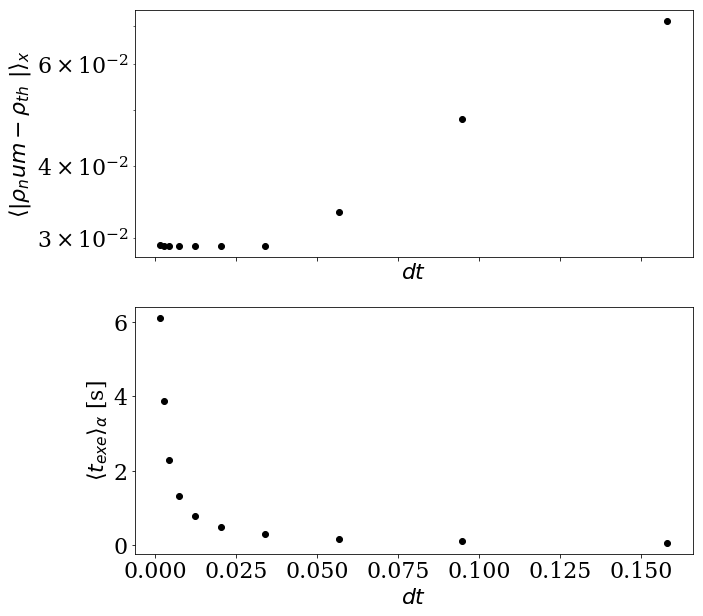

In [11]:
f, (ax1, ax2) = pyplot.subplots(2, 1, sharex=True, figsize=(10,10))

ax1.semilogy(T/nts, errors, 'o', lw=5, alpha = 1.0, color = 'k')
ax1.set_xlabel(r'$dt$')
ax1.set_ylabel(r'$\langle | \rho_num - \rho_{th} | \rangle_{x}$')

ax2.plot(T/nts, times, 'o', lw=5, alpha = 1.0, color = 'k')
ax2.set_xlabel(r'$dt$')
ax2.set_ylabel(r'$\langle t_{exe} \rangle_{\alpha}$ [s]')

pyplot.show()

It seems that the times taken to make the system evolve exlpodes as $dt$ is getting small while the error reaches a plateau around $dt=0.04$.

--> Is it linked whith the bining ?

## Challenge

- Add as systematic contribution to the displacement $dx$,

$$
dx=cdt+\sqrt{2\alpha dt}\cal{N(0,1)}
$$

where $c$ is a constant and analyse the behaviour of the random walk. Can you guess the corresponding equation governing the evolution of the density in this case? What is the analitical solution for an initial Gaussian distribution?



In [12]:
# Initialisation des paramètres du problème

npart_trans=100000

T_trans=50.0
nt_trans=500
dt_trans=T_trans/nt_trans

alpha_trans=2.0
c_trans= 1.5

t_trans = numpy.arange(0,T_trans+dt_trans,dt_trans)
x_trans = numpy.empty([nt_trans+1,npart_trans])

sigma_trans = 1.0
mu_trans = 0
x0_trans = numpy.random.normal(loc=0,scale=sigma_trans,size=npart_trans)
x_trans[0]=x0_trans

# Evolution du système
sqrt_2a_dt_trans = numpy.sqrt(2*alpha_trans*dt_trans)
c_dt_trans = c_trans*dt_trans
for i in range(nt_trans):
    x_trans[i+1]=x_trans[i]+c_dt_trans+sqrt_2a_dt_trans*numpy.random.normal(0,1,npart_trans)

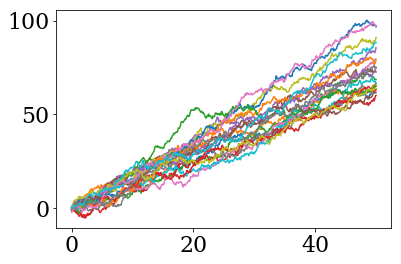

In [13]:
# Visualisation de l'évolution du système pour 20 particules

for i in range(20):
    pyplot.plot(t_trans,x_trans[:,i])

Besides the Brownian motion causing the dispersion of the particles, the system drifts with a constant speed c (as per a translation), thus the analitical evolution equation is:

$$
\rho(x,t)=\frac{1}{\sqrt{2\pi\sigma_t^2}}e^{-\frac{(x-ct)^2}{2\sigma_t^2}}
$$

where $\sigma_t^2 = 2\alpha t+\sigma_0^2$. The density function is still a gaussian but around $ct$ with standard derivation $\sigma_t$.

We can then compare this formula with a simulation by ploting the histogram of density after a the choosen time $T_{end}$ and the curve $\rho(x,T_{end})$.

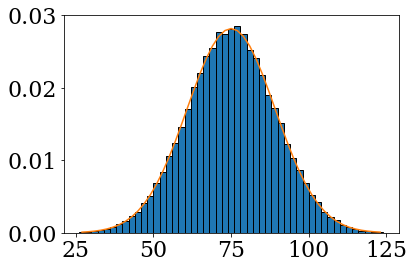

In [14]:
# Visualisation de la répartition finale des particules

# Generate bins centered around 0
binwidth= 2*sigma_trans
bins=numpy.arange(-50+T_trans*c_trans,50+T_trans*c_trans,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
pyplot.hist(x_trans[nt_trans],bins,density=True, edgecolor='k');

# plot analytical solution
sigmat2_trans=2*alpha_trans*T_trans+sigma_trans**2
mut2_trans=T_trans*c_trans
pyplot.plot(bin_centers, numpy.exp(-(bin_centers-mut2_trans)**2/(2.0*sigmat2_trans))/numpy.sqrt(2*numpy.pi*sigmat2_trans))

- Simulate the following random walk with a 'friction' term:

$$
dx=-\gamma x dt + \sqrt{2\alpha dt}\cal{N(0,1)}
$$

Check that the distribution reaches a steady state for $t\rightarrow \infty$. Can you guess the corresponding equation governing the evolution of the density in this case? What is analytical form for the steady state? These last two questions are not easy!

Intuitively, one can see that the extra 'friction' term tends to push the particles towards zero (paticles with negative $x$ position will feel a force pushing them to the right and similarly $x$-positive particles will be pushed to the left). In a more general case, rewriting the random walk as 
$$
dx=-\gamma (x-\mu) dt + \sqrt{2\alpha dt}\cal{N(0,1)}
$$
the particles density should show a maximum at $\mu$. 
Thus the steady state should be a gaussian centered around $\mu$ (in our case $\mu=0$) and the standard deviation should decrease along the evolution as if the particles agglomerate. 

To get more insight into the form of the standard deviation, one can study the dimensions of the different terms used in the evolution equation.
Let write the dimension of distances as $L$, times as $T$ and masses as $M$.

- The standard deviation as the dimension of a length : $[\sigma^2]=L^2$, as one can see in the initial density function, the density as the dimension of the inverse of a length (in 1D) plus the argument of the exponential has to be dimensionless. 
- From there one can deduce the dimension of the $\alpha$ parameter thanks to the formula $\sigma_t^2=2\alpha t+\sigma_i^2 \Rightarrow [\sigma_t^2] = [\alpha t] \Rightarrow [\alpha] = L^2/T$.
- The dimension of the $\gamma$ parameter can be derived from the random walk expression noting that the infinitesimal displacement or time have the dimension, respectively, of distance and time. Hence $[dx]=[\gamma x dt] \Rightarrow L = [\gamma] L T \Rightarrow [\gamma] = 1/T$.

One can thus expect to find a term such as $\alpha/\gamma$ in the expression of squared the sandard deviation of the density at the equilibrium as the friction $\gamma$ will oppose the diffusion process embodied by $\alpha$. 


Now let's make a few simulations to confirm, or infirm, our insights.

First we will check if the system indeed tends to an equilibrium. To do so the standard deviation will be digitally computed by fitting the density with a gaussian distribution at each time step. Then the values found ${\sigma_\text{sim}}^2$ will be ploted agaist the time. We expect it to evolve toward a stable value. Moreover the evolution of the system will be computed for two different initial conditions (a gaussian with standard deviation $\sigma_0=1$ and a dirac distribution that can be seen as a gaussian with $\sigma_0=0$), it is expected that both IC will lead to the same equilibrium.

Then, if the standard deviation does indeed reach an equilibrium, we will investigate its dependency in $\gamma$ and $\alpha$ by plotting plotting $(\sigma_\text{sim}^\text{eq})^2$ for ranges of values of these two parameters.

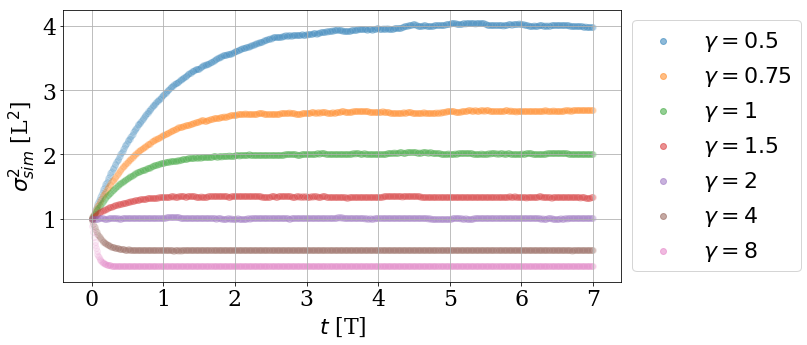

In [15]:
sigmas_t05 = numpy.load('sigmasT_05_7.npy')
sigmas_t075 = numpy.load('sigmasT_075_7.npy')
sigmas_t1 = numpy.load('sigmasT_1_7.npy')
sigmas_t15 = numpy.load('sigmasT_15_7.npy')
sigmas_t2 = numpy.load('sigmasT_2_7.npy')
sigmas_t4 = numpy.load('sigmasT_4_7.npy')
sigmas_t8 = numpy.load('sigmasT_8_7.npy')
gammas_t = numpy.load('gammas_x7.npy')
times = numpy.load('times_0to7.npy')

alpha = 2.
sigma_init = 1.


pyplot.figure(figsize=(10,5))


pyplot.scatter(times, sigmas_t05**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[0])

pyplot.scatter(times, sigmas_t075**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[1])

pyplot.scatter(times, sigmas_t1**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[2])

pyplot.scatter(times, sigmas_t15**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[3])

pyplot.scatter(times, sigmas_t2**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[4])

pyplot.scatter(times, sigmas_t4**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[5])

pyplot.scatter(times, sigmas_t8**2, alpha=0.1, label=r'$\gamma=%g$' %gammas_t[6])


pyplot.xlabel(r'$t$ [T]')
pyplot.ylabel(r'$\sigma_{sim}^2$ [L$^2$]')
leg = pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
pyplot.grid()
pyplot.show()

This first plot does show the evolution of the squared standard deviation to a stable state, such as a relaxation process. Plus it is noticeable that the equilibrium is reached faster when $\gamma$ grows.

Now let's plot the evolution of the system for the two IC described above. The simulation parameters used here are : $\alpha=2$, $\gamma=4$, $dt=0.01$ and $T_{end}=4.0$.

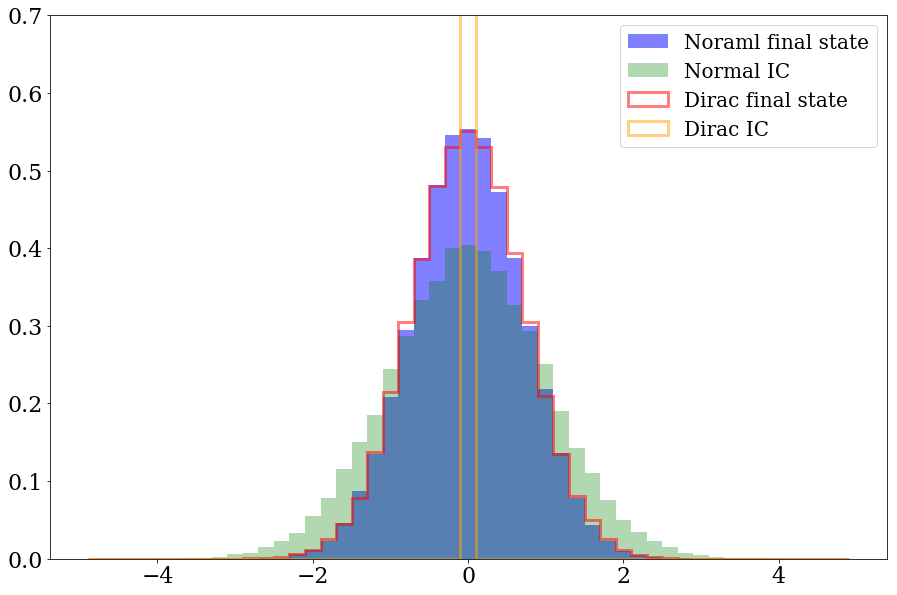

In [16]:
Initial_friction = numpy.load('IS_gaussian.npy')
Initial_friction_3 = numpy.load('IS_dirac.npy')
Final_friction = numpy.load('FS+gaussian_4_001_2_4.npy')
Final_friction_3 = numpy.load('FS+dirac_4_001_2_4.npy')

from scipy.stats import norm

# Generate bins centered around 0
binwidth=0.2
bins=numpy.arange(-5,5,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
pyplot.figure(figsize=(15,10))

# condition initiale : gaussienne

pyplot.hist(Final_friction,bins,density=True, alpha=0.5, label='Noraml final state', color='blue');
pyplot.hist(Initial_friction,bins,density=True, alpha=0.3, label='Normal IC', color='green');

mean_initial,std_initial=norm.fit(Initial_friction)
gauss_fit_initial = norm.pdf(bin_centers, mean_initial, std_initial)
#pyplot.plot(bin_centers, gauss_fit_initial, 'k', ls=':', linewidth=2, c='green'
 #        , label = 'Fit : $\mu$=%.3f, $\sigma=$%.3f' %(mean_initial, std_initial))

mean_final,std_final=norm.fit(Final_friction)
gauss_fit_final = norm.pdf(bin_centers, mean_final, std_final)
#pyplot.plot(bin_centers, gauss_fit_final, 'k', ls=':', linewidth=2, c='blue'
 #        , label = 'Fit : $\mu$=%.3f, $\sigma=$%.3f' %(mean_final, std_final))

# condition initiale : delta dirac

pyplot.hist(Final_friction_3,bins,density=True, alpha=0.5, histtype='step', label='Dirac final state', color='red', lw=3);
pyplot.hist(Initial_friction_3,bins,density=True, alpha=0.5, histtype='step', label='Dirac IC', color='orange', lw=3);

mean_initial_3,std_initial_3=norm.fit(Initial_friction_3)


mean_final_3,std_final_3=norm.fit(Final_friction_3)
gauss_fit_final_3 = norm.pdf(bin_centers, mean_final_3, std_final_3)
#pyplot.plot(bin_centers, gauss_fit_final_3, 'k', ls=':', linewidth=2, c='red'
 #        , label = 'Fit : $\mu$=%.3f, $\sigma=$%.3f' %(mean_final_3, std_final_3))

pyplot.legend(prop={'size': 20})
pyplot.ylim(0,0.7)
pyplot.show()


As expected the same equilibrium density seems to be reached for the two differents ICs. 

This evolution toward equilibrium can be seen on a small movie. The next cell thus displays a video previously saved showing the density state of the system both at time $t$ en $t-1$. These two distribution are overlapping at the end: this is an equilibrium state.

In [17]:
from IPython.display import Video

Video("720p.MOV")

So now we are going to pursue the impact of $\gamma$ and $\alpha$ on the squared standard deviation to develop our insights.

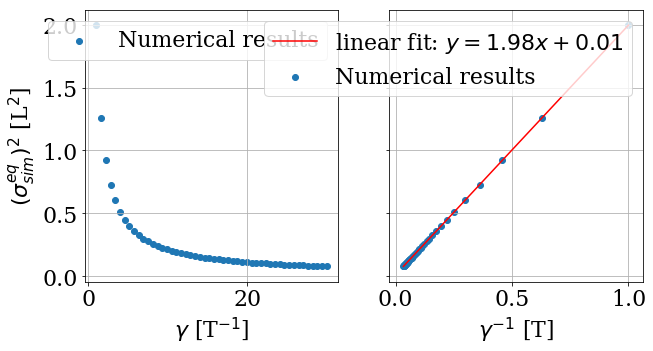

In [19]:
sigmas_gamma = numpy.load('sigmas_eq_of_gammas.npy')
gammas = numpy.load('gammas_for_sigmas_eq.npy')

fit_gammaInv_sigma2 = numpy.polyfit(gammas**(-1), sigmas_gamma**2, 1)


#pyplot.figure(figsize=(10,5))
fig, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True, figsize=(10,5))

ax1.scatter(gammas, sigmas_gamma**2, label='Numerical results')
ax1.set_xlabel(r'$\gamma$ [T$^{-1}$]')
ax1.legend()
ax1.set_ylabel(r'$(\sigma_{sim}^{eq})^2$ [L$^2$]')
ax1.grid()

ax2.scatter(gammas**(-1), sigmas_gamma**2, label='Numerical results')
ax2.plot(gammas**(-1)
         , fit_gammaInv_sigma2[0]*gammas**(-1)+fit_gammaInv_sigma2[1],
         color = 'red',
        label = r'linear fit: $y=%.2f x + %.2f$' %(fit_gammaInv_sigma2[0], fit_gammaInv_sigma2[1]))
ax2.set_xlabel(r'$\gamma^{-1}$ [T]')
ax2.legend()
ax2.grid()

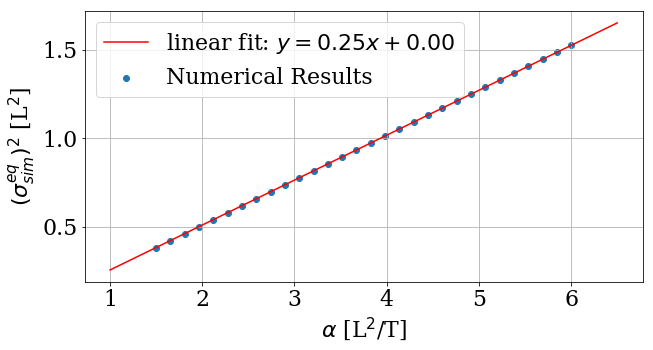

In [20]:
sigmas_alpha_friction = numpy.load('sigmas_eq_of_alpha_friction.npy')
alphas_friction = numpy.load('alphas_friction_for_sigmas_eq.npy')

fit_alpha_sigma2 = numpy.polyfit(alphas_friction, sigmas_alpha_friction**2, 1)

T_end_alpha_friction = 7.
gamma = 4.

pyplot.figure(figsize=(10,5))

alpha_line = numpy.array([1, 6.5])

pyplot.plot(alpha_line,
            fit_alpha_sigma2[0]*alpha_line+fit_alpha_sigma2[1],
            color = 'red',
            label = r'linear fit: $y=%.2f x + %.2f$' %(fit_alpha_sigma2[0], fit_alpha_sigma2[1]))
pyplot.scatter(alphas_friction, sigmas_alpha_friction**2, label='Numerical Results')

pyplot.xlabel(r'$\alpha$ [L$^2$/T]')
pyplot.ylabel(r'$(\sigma^{eq}_{sim})^2$ [L$^2$]')
pyplot.legend()
pyplot.grid()
pyplot.show()

The two previous plots confirm our prior guesses, ie. $(\sigma^{eq})^2\propto \alpha/\gamma$. Plus one can remark that the singularity at $\gamma=0$ is not unphysical as without friction the density tends to be completely flattened as $t$ goes to infinity.

In order to better understand what's going on, one can dig into the motion equation to try to find an analytical expression for the evolution of the density $\rho(x,t)$. Let's try that. 

First it is important to notice that the random walk given by 
$$
dx=-\gamma x dt + \sqrt{2\alpha dt}\cal{N(0,1)}
$$
corresponds to a Fokker-Planck equation that is:
\begin{align} \label{eq:FP_equation}
\frac{\partial \rho}{\partial t}=-\gamma \frac{\partial}{\partial x}\left(x \rho\right)+\alpha \frac{\partial^{2} \rho}{\partial x^{2}}
\end{align}
Solving this equation with an initial density distributed as a gaussian with mean 0 and standard deviation $\sigma_0$, i.e. $$\rho(x,t=0)=\rho_0(x)=\frac{1}{\sqrt{2\pi\sigma_0^2}}e^{-\frac{x^2}{2\sigma_0^2}}$$ will allow a quantitative comparison of the results obtained with what the model used here predicts.

Let's dive into FP equation \eqref{eq:FP_equation} and solve it using Fourier transforms and the method of characteristics.

First the FP equation is transformed using the following convention for Fourier transforms:
$$\mathcal{F}(\rho(x))(k)=\hat{\rho}(k)=\int e^{-i k x} \rho(x) \mathrm{d} x$$
The transformation yields 
$$
\frac{\partial \hat{\rho}}{\partial t}+\gamma k \frac{\partial \hat{\rho}}{\partial x}=-\alpha k^{2} \hat{\rho}
$$
The fourier transform of the initial condition can be obtained using the following relations that can easily be proveed: 
1. $\mathcal{F}({e^{-x^2}})(k)=\sqrt{\pi} \cdot \exp \left(-\frac{k^{2}}{4}\right)$
2. $\widehat{f(a \cdot x)}(k)=\frac{1}{a} \cdot \hat{f}\left(\frac{k}{a}\right) \quad a>0$

Using these, one can directly compute 
$$
\hat{\rho_0}(k)=e^{-\frac{k^2\sigma_0^2}{2}}
$$

Then comes the method of the characteristics, supposing:
$$
\frac{\mathrm{d} \hat{\rho}}{\mathrm{d} t}=\frac{\partial \hat{\rho}}{\partial t}+\frac{\partial \hat{\rho}}{\partial x} \frac{\partial x}{\partial t}=\frac{\partial \hat{\rho}}{\partial t}+\gamma k \partial x \frac{\partial x}{\partial t}
$$
yields $\frac{\mathrm{d} k}{\mathrm{d} t}=\gamma k$, thus 
$$
k=k_{0} e^{\gamma t}
$$

Then on the curves $k(k_0,t)$ the fourier transform of the solution is the solution of the equation $\frac{\mathrm{d} \hat{\rho}}{\mathrm{d} t}=-\alpha k^{2} \hat{\rho}=-\alpha k_{0}^{2} e^{2 \gamma t} \hat{\rho}$. Thus 
$$
\hat{\rho}=\exp \left[-\frac{\alpha k_{0}^{2}}{2 \gamma}\left(e^{2 \gamma t}-1\right)\right] \hat{\rho}_{0}(k_0)
$$
The computation of this equation gives the following solution:
$$
    \hat{\rho}(k,t) = \exp \left[-\frac{k^{2}}{2} \left(\sigma_0^2 e^{-2\gamma t} + \frac{\alpha}{\gamma} \left(1 - e^{-2 \gamma t}\right) \right)  \right] \\
    \hat{\rho}(k,t) = \exp \left[-\frac{k^{2}}{2} \sigma^2(t)  \right]
$$
which is the Fourier transform of a gaussian distribution with mean 0 and standard deviation 
\begin{align} \label{eq:std_dv}
    \sigma^2(t) = \sigma_0^2 e^{-2\gamma t} + \frac{\alpha}{\gamma} \left(1 - e^{-2 \gamma t}\right)
\end{align}

The analytical solution found above seems to fit right the properties we intuitively thought it should have. Plus it tends to an equilibrium value defined by
$$
\lim_{t\to\infty}\sigma^2(t)
$$
Using \eqref{eq:std_dv}, the standard deviation at the equilibrium should thus be
$$
 \sigma_{eq}^2 = \frac{\alpha}{\gamma}
$$

As we could have guessed the system relaxes to its equilibrium state following an exponential decay caracterized by its relaxation time $\tau=1/2\gamma$.

First let's reconsider the plot shown above displaying $\sigma_{sim}^2$ as a function of $t$ and plot, above of the scatter points given by the simulations, the analytical solution for $\sigma^2(t)$ derived before as a dashed line.

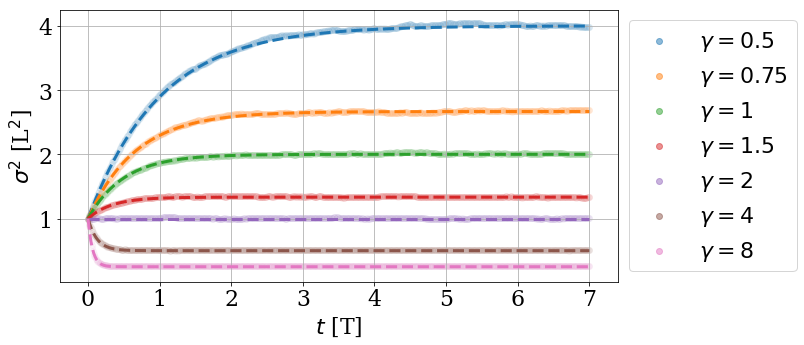

In [21]:
pyplot.figure(figsize=(10,5))


pyplot.scatter(times, sigmas_t05**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[0])

pyplot.scatter(times, sigmas_t075**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[1])

pyplot.scatter(times, sigmas_t1**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[2])

pyplot.scatter(times, sigmas_t15**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[3])

pyplot.scatter(times, sigmas_t2**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[4])

pyplot.scatter(times, sigmas_t4**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[5])

pyplot.scatter(times, sigmas_t8**2, alpha=0.05, label=r'$\gamma=%g$' %gammas_t[6])


for i in range(len(gammas_t)):
    pyplot.plot(times,
            sigma_init*numpy.exp(-2*times*gammas_t[i])+(alpha/gammas_t[i])*(1-numpy.exp(-2*times*gammas_t[i])),
               lw = 3., ls = '--')


pyplot.xlabel(r'$t$ [T]')
pyplot.ylabel(r'$\sigma^2$ [L$^2$]')
leg = pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)
pyplot.grid()
pyplot.show()

The analytical solution given by
$$
    \sigma^2(t) = \sigma_0^2 e^{-2\gamma t} + \frac{\alpha}{\gamma} \left(1 - e^{-2 \gamma t}\right)
$$
seems to fit the numerical results well. The study can be pursued by comparing the values fitted before for $(\sigma_{sim}^{eq})^2(\alpha)$ and $(\sigma_{sim}^{eq})^2(\gamma^{-1})$ with the expected analytical values. 

For the recall, these simulations were led with $\sigma_0=1$ and respectively $\gamma=4$ and $\alpha=2$. And the expected squared standard deviation at the stable state is $(\sigma^{eq})^2=\alpha/\gamma$, thus we should find something like 

$$
(\sigma_{sim}^{eq})^2(\alpha) = a \alpha + b
$$

with $a=1/\gamma=0.25$ and $b=0$, and 

$$
(\sigma_{sim}^{eq})^2(\gamma^{-1}) = c \gamma^{-1} + d
$$

with $c=\alpha=2$ and $d=0$.

In [22]:
print(r'Squared Standard Deviation as a function of alpha')
print('fitted values: a=', fit_alpha_sigma2[0], ' and b = ', fit_alpha_sigma2[1])

print(r'Squared Standard Deviation as a function of gamma')
print('fitted values: c=', fit_gammaInv_sigma2[0], ' and d = ', fit_gammaInv_sigma2[1])

Squared Standard Deviation as a function of alpha
fitted values: a= 0.25415193201605885  and b =  5.675545814855576e-16
Squared Standard Deviation as a function of gamma
fitted values: c= 1.9845688613223171  and d =  0.011513167730407059


The small differencies observed here can be a result of the approximations of the model and its inherent randomness but it can also be linked to the digital discretisation of time. That's why a convergence study is led to confirm that the simulations tend to the value found analytically as $dt$ gets smaller.

To do so the difference between an average of squared standard deviation for ten simulation at $\alpha=2$, $\gamma=4$ and $T_{end}=4$ constant and the reference value is studied for a range of time steps from $dt=0.001$ to $dt=0.05$.

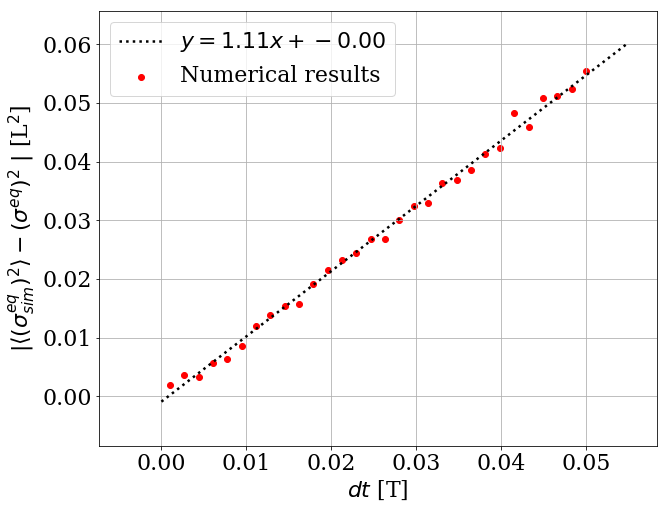

In [23]:
dts_conv = numpy.load('dts_conv_0001to005.npy')
sigmas_dt_conv = numpy.load('sigmas_dt_conv_Tend4_gamma4_alpha2_av10.npy')

fit_conv = numpy.polyfit(dts_conv, numpy.abs(sigmas_dt_conv**2-alpha/gamma), 1)

pyplot.figure(figsize=(10,8))

pyplot.scatter(dts_conv, numpy.abs(sigmas_dt_conv**2-alpha/gamma),
               c='r',
              label='Numerical results')

dts_fit = numpy.linspace(0,0.055, 2)
pyplot.plot(dts_fit, fit_conv[0]*dts_fit+fit_conv[1],
            c='k', ls=':', lw=2.5,
           label='$y= %.2f x + %.2f$' %(fit_conv[0], fit_conv[1]))

pyplot.xlabel(r'$dt$ [T]')
pyplot.ylabel(r'$|\langle(\sigma_{sim}^{eq})^2\rangle - (\sigma^{eq})^2 |$ [L$^2$]')
pyplot.legend()
pyplot.grid()
pyplot.show()

The convergence analysis shows indeed a convergence toward the analytical solution derived of first order in the time step $dt$.

##### TODO :
- [x] Convergence study (dt combined with bining)
- [x] Test different IC
- [ ] Combine friction with drifting

In [2]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())